In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests, json
from datetime import datetime

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.float_format = '{:.2f}'.format

## Data

In [3]:
#crowdsourced data from covid19india.org
data = pd.read_csv('https://api.covid19india.org/csv/latest/statewise_tested_numbers_data.csv')

In [4]:
#state-wise population estimates from UIDAI
state_population_data = pd.read_csv('state_population_2019_projected_uidai.csv')

In [5]:
#global data on testing from Our World in Data. Use this for India time-series
owid_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/testing/covid-testing-all-observations.csv')

In [6]:
#case counts of India from Popper.AI
trend_data = requests.get('https://popper.ai/ncov19/trend_data.json')
india_cases = json.loads(trend_data.content)['data']['India']['confirmed']

india_df = pd.DataFrame(india_cases)
india_df.columns = ['timestamp', 'confirmed_cases']
india_df['Date'] = pd.to_datetime(india_df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000).date()))

## Analysis

In [7]:
#Manually fixing errors
#covid19india.org data had minor errors which I manually fixed here. Problem with date formatting. 
#They might get fixed, and new ones may come. Do check for erratic dates
data['Updated On'] = data['Updated On'].replace(to_replace=['02/05/2050'], value='02/05/2020')
data['Updated On'] = data['Updated On'].replace(to_replace=['04/02/2020'], value='02/04/2020')

data['Updated On'] = pd.to_datetime(data['Updated On'], format='%d/%m/%Y')

#### Merging different data sets to get one dataframe 

In [8]:
#raw data frpm covid19india has many columns. selecting the ones needed for testing analysis
#sel_data will have state-wise testing statistics
sel_data = data[['Updated On', 'State', 'Total Tested', 'Positive', 'Unconfirmed']]
sel_data.columns = ['date', 'state', 'total_tests', 'positive', 'delay']
total_tests = pd.DataFrame(sel_data.groupby('date').sum()['total_tests'])

In [9]:
#get india time series from OurWorldInData
india_data = owid_data[owid_data.Entity=='India - samples tested']
india_data = india_data[['Date', 'Cumulative total']]
india_data.Date = pd.to_datetime(india_data['Date'], format='%Y-%m-%d')

#Merge test time series with case count time series
india_data = india_data.merge(india_df[['Date', 'confirmed_cases']], how='left')

india_data.columns = ['date', 'total_tests', 'positive']
india_data['state'] = 'India'

In [10]:
#add all-India data to state-wise stats 
sel_data = sel_data.append(india_data)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [11]:
india_data.columns = ['date', 'total_tests_india', 'positive_india', 'state']
india_data_merge = india_data[['date', 'total_tests_india', 'positive_india']]

In [12]:
full_data = sel_data.merge(india_data_merge, on='date')
full_data = full_data.merge(state_population_data, how='left', on='state')

#### Calculating variables: testing rate, test positivity rate, comparisons of state with all India figures

In [13]:
india_population = state_population_data[state_population_data.state=='India'].values[0][1]

full_data['nat_test_pc'] = round(full_data.total_tests*100.0/full_data.total_tests_india,2)
full_data['nat_positive_pc'] = round(full_data.positive*100.0/full_data.positive_india,2)

full_data['new_tests'] = -full_data.groupby('state')['total_tests'].shift(1).sub(full_data['total_tests'])
full_data['test_per_million'] = full_data.total_tests*1000000/full_data.population_2019
full_data['india_test_per_million'] = full_data.total_tests_india*1000000/india_population

full_data['positive_per_million'] = full_data.positive*1000000/full_data.population_2019
full_data['india_positive_per_million'] = full_data.positive_india*1000000/india_population

full_data['test_positive_rate'] = round(full_data.positive*100.0/full_data.total_tests,2)
full_data['india_test_positive_rate'] = round(full_data.positive_india*100.0/full_data.total_tests_india,2)



#### Data for the latest date

In [14]:
latest = full_data.dropna(subset=['total_tests']).sort_values('total_tests').drop_duplicates(['state'],keep='last')

## Charts

In [15]:
plt.style.use('seaborn-white')
palette = plt.get_cmap('Set1')
#plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

#### State-wise testing rate

In [16]:
plot_data_total = full_data[['date', 'state', 'test_per_million']]
plot_data_total = plot_data_total.drop_duplicates(['date', 'state'], keep='last') 
plot_data_total = plot_data_total.pivot(index='date', columns='state', values='test_per_million')
plot_data_total = plot_data_total[plot_data_total.index>'2020-04-01']
plot_data_total = plot_data_total.reset_index()
order = full_data.groupby('state').max()['test_per_million'].sort_values(ascending=False).index

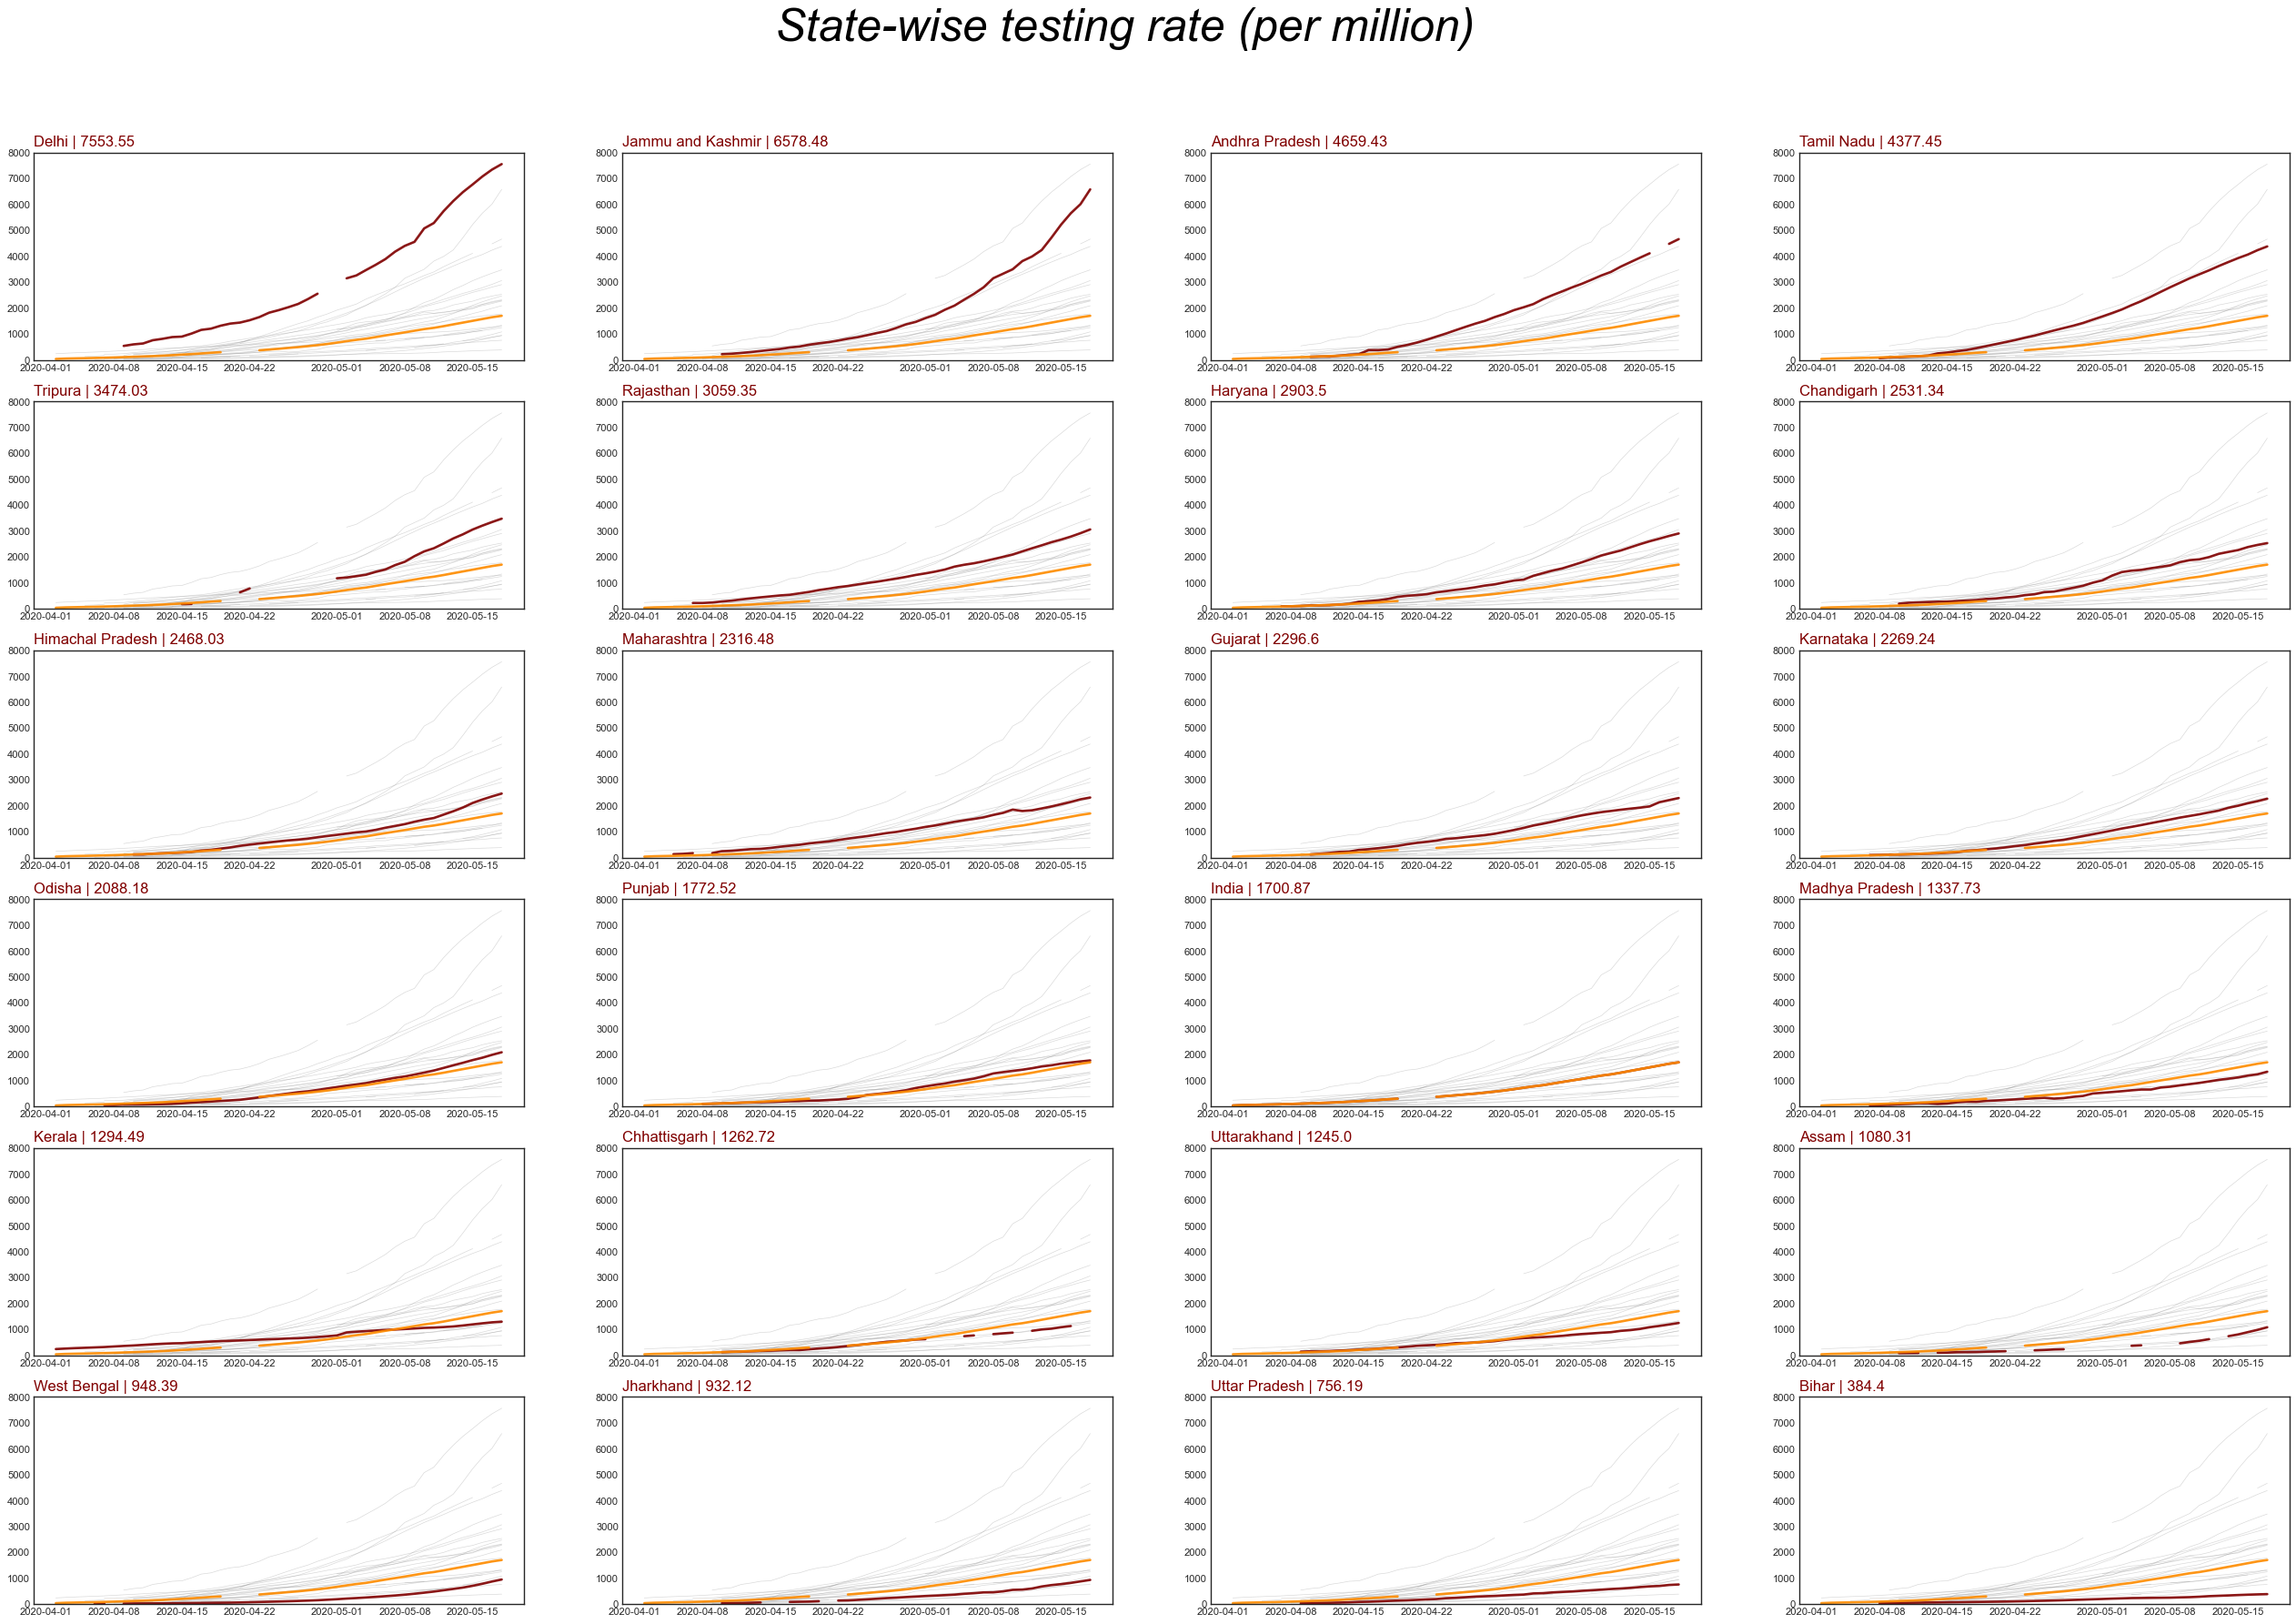

In [17]:
#plotting for states which have at least 50 cases. Also adding Telangana as testing data is not available
drop_states = list(latest[latest.positive<50].state.unique()) + ['Telangana']

df = plot_data_total.drop(drop_states, axis=1)#[['date', 'Andhra Pradesh', 'Madhya Pradesh', 'India', 'Bihar', 'Kerala', 'Delhi']]
num=0
plt.figure(figsize=(40, 40), dpi= 80, facecolor='w', edgecolor='k')
column_order = order.drop(drop_states)
for column in column_order: #df.drop('date', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(9,4, num)
 
    #plot every groups, but discreet
    for v in df.drop('date', axis=1):
        plt.plot(df['date'], df[v], marker='', color='grey', linewidth=0.6, alpha=0.3)
 
    # Plot the lineplot
    plt.plot(df['date'], df[column], marker='', color='maroon', linewidth=2.4, alpha=0.9, label=column)
    plt.plot(df['date'], df['India'], marker='', color='darkorange', linewidth=2.4, alpha=0.9, label=column)
 
    # Same limits for everybody!
#     plt.xlim(0,10)
    plt.ylim(0,8000)
 
    # Not ticks everywhere
#     if num in range(7) :
#         plt.tick_params(labelbottom='off')
#     if num not in [1,4,7] :
#         plt.tick_params(labelleft='off')
 
    # Add title
    plt.title(column + " | " + str(round(df[column].tail(1).values[0],2)), loc='left', fontsize=15, fontweight=5, color='maroon')
 
# general title
plt.suptitle("State-wise testing rate (per million)", fontsize=45, fontweight=3, color='black', style='italic', y=0.93)
plt.savefig('test_rate.svg')
# Axis title
# plt.text(0.5, 0.02, 'Time', ha='center', va='center')
# plt.text(0.06, 0.5, 'Note', ha='center', va='center', rotation='vertical')

#### State-wise test positivity rate

Note: chart code below is same as the above. If you want to make small multiples for any other variable, just tweak the selected variable.

In [18]:
plot_data_total = full_data[['date', 'state', 'test_positive_rate']]
plot_data_total = plot_data_total.drop_duplicates(['date', 'state'], keep='last') 
plot_data_total = plot_data_total.pivot(index='date', columns='state', values='test_positive_rate')
plot_data_total = plot_data_total[plot_data_total.index>'2020-04-01']
plot_data_total = plot_data_total.reset_index()
order = full_data.groupby('state').max()['test_positive_rate'].sort_values(ascending=False).index

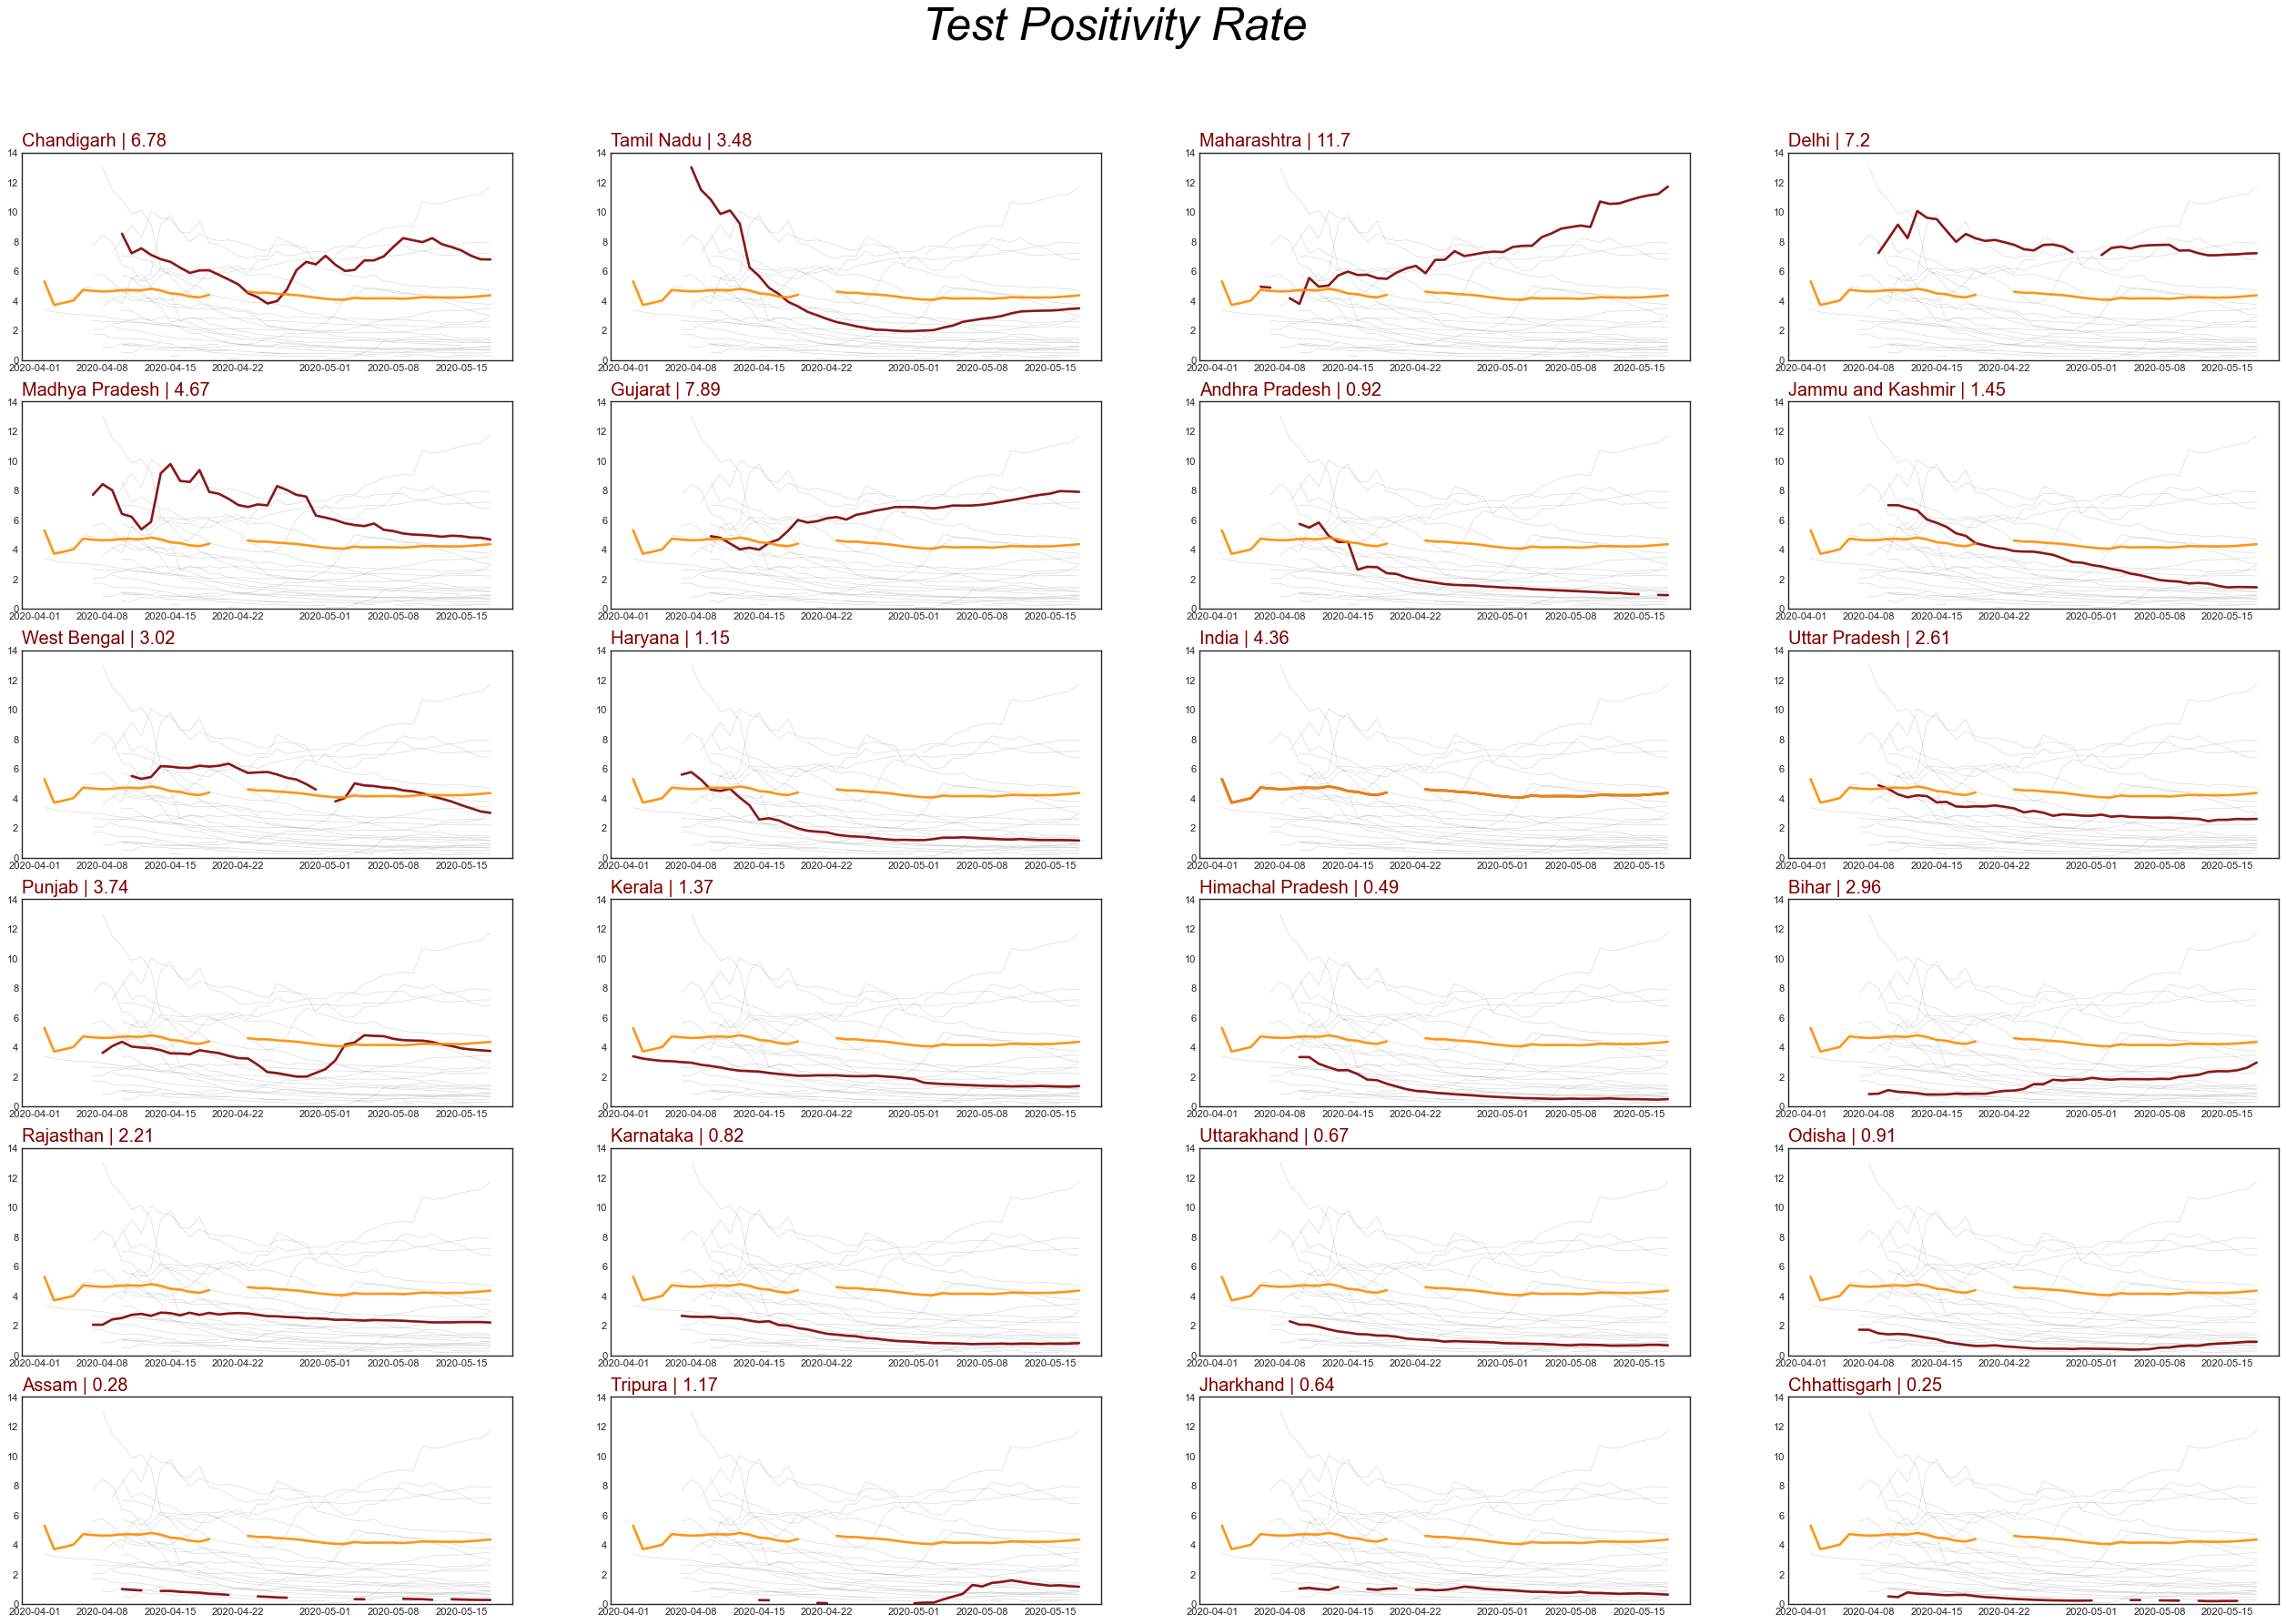

In [19]:
#plotting for states which have at least 50 cases. Also adding Telangana as testing data is not available
drop_states = list(latest[latest.positive<50].state.unique()) + ['Telangana']

df = plot_data_total.drop(drop_states, axis=1)#[['date', 'Andhra Pradesh', 'Madhya Pradesh', 'India', 'Bihar', 'Kerala', 'Delhi']]
num=0
plt.figure(figsize=(40, 40), dpi= 80, facecolor='w', edgecolor='k')
column_order = order.drop(drop_states)
for column in column_order: #df.drop('date', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(9,4, num)
 
    #plot every groups, but discreet
    for v in df.drop('date', axis=1):
        plt.plot(df['date'], df[v], marker='', color='grey', linewidth=0.6, alpha=0.3)
 
    # Plot the lineplot
    plt.plot(df['date'], df[column], marker='', color='maroon', linewidth=2.4, alpha=0.9, label=column)
    plt.plot(df['date'], df['India'], marker='', color='darkorange', linewidth=2.4, alpha=0.9, label=column)
 
    # Same limits for everybody!
#     plt.xlim(0,10)
    plt.ylim(0,14)
 
    # Not ticks everywhere
#     if num in range(7) :
#         plt.tick_params(labelbottom='off')
#     if num not in [1,4,7] :
#         plt.tick_params(labelleft='off')
 
    # Add title
    #plt.title(column, loc='left', fontsize=15, fontweight=5, color='maroon')
    plt.title(column + " | " + str(round(df[column].tail(1).values[0],2)), loc='left', fontsize=18, fontweight=5, color='maroon')

#plt.text(10.2, df.India.tail(1), 'India', horizontalalignment='left', size='small', color='orange')
# general title
plt.suptitle("Test Positivity Rate", fontsize=45, fontweight=10, color='black', style='italic', y=0.93)
plt.savefig('test_positivity_rate.svg')
# Axis title
# plt.text(0.5, 0.02, 'Time', ha='center', va='center')
# plt.text(0.06, 0.5, 'Note', ha='center', va='center', rotation='vertical')

#### Comparing states: % of tests conducted vs % of total detected cases in India

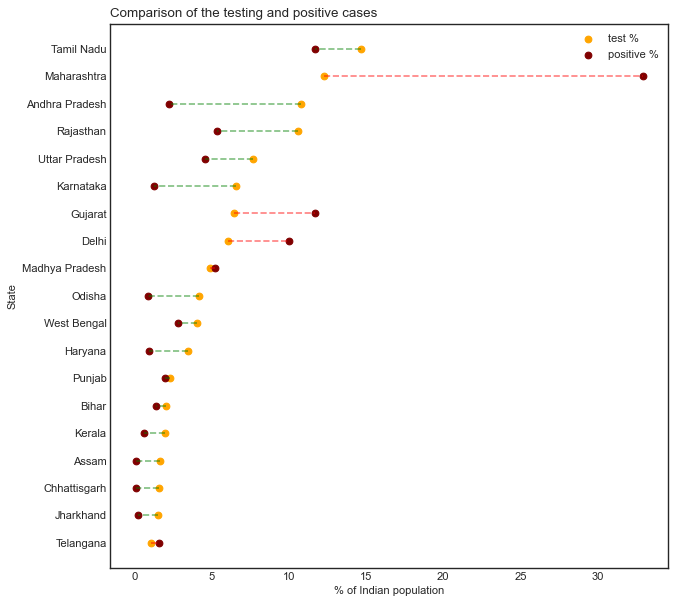

In [20]:
df = latest
df = df[df.state!='India']
df = df[df.population_pc>1]

#color: red if % of positives is greater than % of tests
df['color'] = df.apply(lambda row: 'green' if row.nat_test_pc> row.nat_positive_pc else 'red', axis=1)

# Reorder it following the values of the first value:
ordered_df = df.sort_values(by='nat_test_pc')

my_range=range(1,len(df.index)+1)
 
# The vertical plot is made using the hline function
import seaborn as sns
plt.figure(figsize=(9, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.hlines(y=my_range, xmin=ordered_df['nat_test_pc'], xmax=ordered_df['nat_positive_pc'], color=df['color'], linestyles='dashed', alpha=0.5)

plt.scatter(ordered_df['nat_test_pc'], my_range, color='orange', alpha=1, label='test %')

plt.scatter(ordered_df['nat_positive_pc'], my_range, color='maroon', alpha=1 , label='positive %')

plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_df['state'])
plt.title("Comparison of the testing and positive cases", loc='left')
plt.xlabel('% of Indian population')
plt.ylabel('State')
plt.savefig('dot_plot_comparison.svg')